** Módulo de Herramientas de Análisis - Python **

** Máster en Data Science UAH **

Roberto Santamaría Ayuso

Dataset escogido: base de datos de comercio internacional de la ONU, disponible en https://comtrade.un.org/data/doc/api/


---

**NOTA**: la API gratuita de Comtrade impone límites al número de peticiones, 1 por segundo y 100 por hora, por lo que los ficheros de este ejercicio tardan en descargarse entre 1 y 2 horas. Este notebook incluye el código para la descarga, limpieza y consolidación de datos, pero ofrece la posibilidad de descargar los ficheros, ya limpios y consolidados, desde Github.

Se puede cambiar a True el siguiente flag para forzar la descarga de todos los ficheros (~ 250 MB, entre 1 y 2 horas); en este caso los ficheros intermedios y finales se escriben a disco. Si se mantiene en False se descargarán desde Github (~ 17 MB) y no se escriben datos a disco.

---

In [1]:
# por defecto, descargar ficheros ya consolidados y limpios desde Github
# cambiar a True para ejecutar las llamadas a la API
get_data_from_API = True
tradefile_github = "https://github.com/srayuso/dsuah-comtrade/blob/master/trade2015.zip?raw=true"
availabilityfile_github = "https://github.com/srayuso/dsuah-comtrade/blob/master/comtrade_availability.csv?raw=true"
metadatafile_github = "https://github.com/srayuso/dsuah-comtrade/raw/master/wb_countries_metadata.csv"

**Tabla de contenidos**
- [Resumen](#resumen)
- [Planteamiento](#plan)
- [Inicialización](#init)
- [Descarga de datos](#descarga)
- [Análisis](#analisis)
  - [Pregunta 1: ¿Hay países principalmente exportadores, o principalmente importadores?](#Q1)
  - [Pregunta 2: ¿Los intercambios comerciales se concentran en áreas geográficas cercanas?](#Q2)
  - [Pregunta 3: ¿Hay países que monopolizan la exportación de ciertos bienes?](#Q3)
- [Conclusiones y próximos pasos](#conclusiones) 

<a id="resumen"></a>
## Resumen
En este notebook vamos a analizar datos de comercio internacional recopilados por la ONU y ofrecidos en el portal [UN Comtrade](https://comtrade.un.org/). Estos datos son enviados por los países al *Department of Economic and Social Affairs* (DESA), una agencia dependiente de la ONU. Se pueden consultar agregados por mes y por año, y agrupados en diversos niveles de categorías de bienes y servicios. Comtrade dispone de una API REST que permite consultas gratuitas con ciertas limitaciones.

En primer lugar plantearemos preguntas con las que enfocar el análisis del dataset. A continuación, descargaremos los datos con la API, los consolidaremos y los limpiaremos. En el siguiente paso trataremos de contestar las preguntas una por una, apoyando los resultados con gráficos.

<a id="plan"></a>
## Planteamiento

La información sobre comercio internacional ayuda a entender las relaciones entre países, el poder económico de los mismos y, de una manera global, los movimientos mercantiles a nivel mundial. Los datos ofrecidos por la DESA son exhaustivos, llegando al detalle por mes, por categoría e incluso por provincias o regiones en algunos casos. Las categorías son tan dispares como *Edible fruit and nuts; peel of citrus fruit or melons* o *Aluminium and articles thereof*, y cubren tanto bienes materiales como servicios.

Con estos datos podemos abordar cuestiones como:
- ¿Hay países principalmente exportadores, o principalmente importadores?
- ¿Los intercambios comerciales se concentran en áreas geográficas cercanas?
- ¿Hay países que monopolizan la exportación de ciertos bienes?

El análisis de estos datos presenta ciertas dificultades inherentes a la recopilación de los mismos: 
- Aunque un único agente agrega los datos, cada país es responable de enviarlos. En algunos casos los datos son reportados años más tarde de la fecha a la que se refieren.
- La jerarquía de categorías se divide en 6 niveles, pero no todos los países reportan al mayor nivel de detalle. Por ejemplo, en el primer nivel de la jerarquía encontramos *LIVE ANIMALS; ANIMAL PRODUCTS*. Ésta se subdivide en 5 categorías, entre ellas *Live Animals*. Ésta, a su vez, se subdivide en dos niveles más hasta llegar a una categoría de *Live poultry* > *Weighing no more than 185 g* > *Guinea fowls*. Algunos países llegan a este nivel, pero otros se limitan al primer o segundo nivel de la jerarquía. La lista de categorías se puede consultar en http://www.wcoomd.org/en/topics/nomenclature/instrument-and-tools/hs-nomenclature-2017-edition/hs-nomenclature-2017-edition.aspx.

Además, la API gratuita de Comtrade impone ciertos límites:
- Cada petición está limitada a 50.000 registros (o líneas de CSV).
- No se pueden realizar más de 100 peticiones por hora ni más de 1 petición por segundo.

Simplificaremos el análisis limitándonos a **materias primas y bienes manufacturados** (denominados *commodities* en la documentación) intercambiados durante el año **2015** y reportados en el **segundo nivel de categorización**. La justificación de escoger este año se encuentra en la sección [3.2](#disponibilidad). Todos los valores del volumen de intercambios comerciales se indican en dólares de Estados Unidos.


<a id="descarga"></a>
## Descarga  y limpieza

<a id="init"></a>
### Inicialización

Cargamos las librerías que necesitaremos a lo largo del notebook.

In [2]:
import requests as rq
import pandas as pd
import numpy as np
from io import StringIO, BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import json
import time
import seaborn as sns

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

print("Pandas version:", pd.__version__)
print("Requests version:", rq.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

Pandas version: 0.20.3
Requests version: 2.18.4
Numpy version: 1.13.3
Matplotlib version: 2.1.0
Seaborn version: 0.8.0


<a id="disponibilidad"></a>
### Disponibilidad de datos

En primer lugar vamos a identificar un año para el que dispongamos de suficiente información. Comtrade dispone de una consulta sobre disponibilidad de datos en https://comtrade.un.org/data/da. Vamos a comprobarcuál es el último año sobre el que han informado los países.

In [3]:
# a lo largo de esta seccion bifurcaremos el código en función de si queremos depender de la API o
# de los datos ya consolidados

if get_data_from_API:
    availability_url = 'https://comtrade.un.org/api/refs/da/view?fmt=csv'
    availability_resp = rq.get(availability_url)

    # la API devuelve un CSV en el cuerpo de la respuesta
    # inicializamos un dataframe desde esta string, sin escribir en disco
    availability_df = pd.read_csv(StringIO(availability_resp.text))
    availability_df.to_csv("comtrade_availability.csv", index=False)
else:
    availability_resp = rq.get(availabilityfile_github)
    availability_df = pd.read_csv(StringIO(availability_resp.text))
    
availability_df.head()

,type,freq,px,r,rDesc,ps,TotalRecords,isOriginal,publicationDate,isPartnerDetail
0,COMMODITIES,ANNUAL,BEC,100,Bulgaria,1998,4325,0,2005-06-20T00:00:00,1
1,COMMODITIES,ANNUAL,BEC,100,Bulgaria,1999,4371,0,2005-06-20T00:00:00,1
2,COMMODITIES,ANNUAL,BEC,100,Bulgaria,2000,5253,0,2014-12-12T00:00:00,1
3,COMMODITIES,ANNUAL,BEC,100,Bulgaria,2001,5494,0,2014-12-12T00:00:00,1
4,COMMODITIES,ANNUAL,BEC,100,Bulgaria,2002,5664,0,2014-12-12T00:00:00,1


In [4]:
# filtramos los datos de bienes materiales y con frecuencia anual
# después agrupamos por país (rDesc) y año (ps)
# acabamos agrupando por año y contamos cuántos países han reportado cada año

countries_reported_by_year_df = (
    availability_df[((availability_df['type'] == 'COMMODITIES') & (availability_df['freq'] == 'ANNUAL'))]
    .groupby(by=["rDesc", "ps"], as_index=False)
    .count()
    .groupby(by="ps", as_index=False)
    .count()[["ps", "rDesc"]]
    .sort_values(by="ps", ascending=False)
)


countries_reported_by_year_df.head()

,ps,rDesc
54,2016,144
53,2015,155
52,2014,160
51,2013,167
50,2012,171


Hay 144 países que han reportado datos hasta 2016. En 2015 disponemos de datos de 155 países, en 2014, de 160, etc. Estos números reflejan que el dataset es sólo relativamente fiable, ya que hay más de 190 países en el mundo y sólo tenemos información actualizada de menos del 75%.

Usaremos un valor de compromiso, relavitamente reciente pero con suficiente infromación, y analizaremos los datos de **2015**.

### Descarga de datos por país

Como se ha comentado, la descarga de datos está condicionada por las limitaciones de la API. Para no llegar al límite de registros por petición, 50.000, haremos una petición por país de origen. Se entiende como origen al país que ha reportado la transacción: exportador en exportaciones e importador en importaciones. Parece poco lógico, pero los datos siguen esa nomenclatura y nos ceñiremos a ella.

Queremos automatizar la descarga, así que controlaremos los tiempos entre peticiones y los errores que pueda devolvernos la API. El resultado será un fichero CSV por país. Una vez dispongamos de todos los ficheros, consolidaremos todos los ficheros en uno.

A continuación configuramos los parámetros de las peticiones de la API. La documentación está disponible en https://comtrade.un.org/data/doc/api/#DataRequests.

In [5]:
# configuración inicial: datos de 2015, agregados por año, segundo nivel de jerarquía

base_url = 'https://comtrade.un.org/api/get'

params = {
    'ps': '2015', # período: puede ser un año '2015', un mes '201301' o 'recent' para los 5 últimos
    'freq': 'A', # Anual o Mensual
    'px': 'HS', # código de clasificación; Harmonized System es el más estándar
    'r': '', # país origen de la transacción 
    'p': 'all', # país destino de la transacción
    'rg': 'all', # dirección de la trasacción: importación (1), exportación (2) o ambos (all)
    'cc': 'AG2', # nivel de la jerarquía
    'type': 'C', # tipo: bienes materiales (C) o servicios (S)

    'fmt': 'csv', # formato de salida: csv o json
    'head': 'M', # encabezados amigables para humanos (H) o para máquinas (M)
    'max': '50000' # número máximo de registros; 50000 es el máximo para consultas gratuitas
}

El filtro por país de la API requiere un código numérico propio. Podemos obtenerlo de la tabla de disponibilidad de datos que utilizamos en el primer apartado, filtrando los datos anuales de 2015.

In [6]:
# rDesc se refiere al nombre del país y r al código numérico
country_codes = (availability_df[ ((availability_df['type'] == 'COMMODITIES') 
                                & (availability_df['freq'] == 'ANNUAL')
                                & (availability_df['ps'] == 2015))]
                               [['rDesc', 'r']]
                                .drop_duplicates())
print("Número de países:", country_codes.shape[0])
country_codes.head()

Número de países: 155


,rDesc,r
17,Bulgaria,100
25,Myanmar,104
44,Burundi,108
63,Belarus,112
80,Cambodia,116


Ya podemos descargar los datos de cada país. Para ello vamos a hacer un bucle sobre todos los códigos de país, haciendo una petición a la API para cada código. La descarga puede tardar un par de horas debido al límite de 100 peticiones por hora. Descargaremos los CSV a un directorio temporal para evitar reiniciar la descarga en caso problemas en la red o en el kernel.

**NOTA**: hay varias sentencias de consola en las que se asume que el notebook se ejecuta sobre Linux o Mac OSX.

In [7]:
if get_data_from_API:
    folder = "trade2015"
    !mkdir -p {folder}

    # límite por hora: código 401 y mensaje "USAGE LIMIT: Hourly usage limit of 100 actions reached. You may resume use of this service at 2018-01-09T12:51:25Z."
    # límite por segundo: código 401 y mensaje "

    # aprox. 250 MB en 153 archivos

    i = 0
    max_retries = 20 # en caso de error lo intentamos otra vez hasta este máximo 
    retries = 0
    wait_errors = 60 * 5 # esperamos 5 minutos entre errores
    while i < country_codes.shape[0]:
        name, code = country_codes.iloc[i] 
        fileExists = !ls {folder}/{code}.csv
        if ('cannot' not in fileExists[0]):
            print("Ya en disco:", name, "| ", end='')
            i += 1
            retries = 0
            continue
        print("Descargando:", name, "- ", end='')
        params['r'] = code
        response = rq.get(base_url, params=params)
        if (response.status_code != 200):
            print("\nError descargando, reintentando... (", response.text, ")")
            retries += 1
            if retries >= max_retries:
                print("\nDemasiados errores; revise el mensaje y reintente de nuevo.")
                print(response.text)
                break
            else:
                time.sleep(wait_errors)
        else:
            print("recibidos", len(response.text) // 1024, "KB | ", end='')
            f = open(folder + "/" + str(code) + ".csv", "w")
            f.write(response.text)
            f.close()
            time.sleep(1)
            i += 1
            retries = 0
else:
    print("Notebook configurado para descargar los datos ya consolidados desde Github.")

Ya en disco: Bulgaria | Ya en disco: Myanmar | Descargando: Burundi - recibidos 365 KB | Descargando: Belarus - recibidos 1320 KB | Descargando: Cambodia - recibidos 712 KB | Descargando: Algeria - recibidos 973 KB | Descargando: Cameroon - recibidos 928 KB | Descargando: Canada - recibidos 5147 KB | Descargando: Cabo Verde - recibidos 575 KB | Descargando: Cayman Isds - recibidos 140 KB | Descargando: Central African Rep. - recibidos 179 KB | Descargando: Sri Lanka - recibidos 1860 KB | Descargando: Chile - recibidos 1613 KB | Descargando: China - recibidos 4217 KB | Descargando: Colombia - recibidos 1688 KB | Descargando: Costa Rica - recibidos 1461 KB | Descargando: Croatia - recibidos 1626 KB | Descargando: Cyprus - recibidos 1488 KB | Descargando: Czechia - recibidos 2929 KB | Descargando: Benin - recibidos 560 KB | Descargando: Denmark - recibidos 3060 KB | Descargando: Dominican Rep. - recibidos 1454 KB | Descargando: Ecuador - recibidos 1245 KB | Descargando: El Salvador - reci

### Consolidación y limpieza

Una vez descargados los datos de cada país, podemos consolidarlos en un único dataframe. En el mismo paso seleccionaremos sólo las columnas de interés. Finalmente guardaremos el dataframe en un CSV para poder reanudar el análisis sin necesidad de descargar o consolidar todos los ficheros de nuevo.



In [8]:
if get_data_from_API:
    # este código funciona sólo en Linux y Mac OSX
    files = !ls {folder}
    dfs = []
    for f in files:
        # leemos cada fichero, descartamos las columnas inútiles y acumulamos en una lista de dataframes
        df = pd.read_csv(folder + "/" + f)
        df = df[["rtTitle", "rt3ISO", "rtCode", "rgDesc", "ptTitle", "pt3ISO", "ptCode", "pfCode", "period","TradeValue", "cmdDescE", "cmdCode"]]
        dfs.append(df)
    # concatenamos todos los dataframes y renombramos las columnas para que tengan sentido
    df = pd.concat(dfs, ignore_index=True)
    df.rename(columns={"rtTitle": "Source", "rt3ISO": "SourceISO", "ptTitle": "Destination", "pt3ISO": "DestinationISO", 
                       "rgDesc": "Direction", "period": "Year", "cmdDescE": "Description", "cmdCode": "CommodityCode"},
              inplace=True)

    print("Número de registros:",df.shape[0])
    print("Número de países:",len(pd.unique(df['Source'])))
    df.head()
else:
    print("Notebook configurado para descargar los datos ya consolidados desde Github.")

Número de registros: 1481099
Número de países: 155


Algunos registros no corresponden a países sino a regiones como *World* o *EU-28*. Si bien estos datos agregados pueden ser de interés, inicialmente vamos a centrarnos en las relaciones entre países individuales. Para ellos, vamos a eliminar los registros de estas regiones. Eliminaremos además los registros con NA, ya que nos impedirán progresar en el análisis.

In [9]:
if get_data_from_API:
    skip_regions = ['Other Asia, nes',
                    'EU-28',
                    'World',
                    'Areas, nes',
                    'Other Africa, nes',
                    'Oceania, nes',
                    'LAIA, nes',
                    'North America and Central America, nes',
                    'Free Zones',
                    'Special Categories']

    num_reg = df.shape[0]
    # descartamos los registros en los que el origen o el destino no sean un país sino una región agregada
    df = df[(~df['Source'].isin(skip_regions))]
    df = df[(~df['Destination'].isin(skip_regions))]
    # algunos registros se refieren a re-exportaciones o re-importaciones que no estamos analizando
    df = df[(df['Direction'] == 'Export') | (df['Direction'] == 'Import')]
    num_reg_skip = df.shape[0]
    df.dropna(axis=0, how='any', inplace=True)
    num_reg_na = df.shape[0]
    print("Registros en zonas agregadas:", str(num_reg-num_reg_skip))
    print("Registros con NA:", str(num_reg_skip-num_reg_na))
    print("Registros útiles:",num_reg_na)
else:
    print("Notebook configurado para descargar los datos ya consolidados desde Github.")

Registros en zonas agregadas: 172331
Registros con NA: 3245
Registros útiles: 1305523


Otro campo que puede generar errores durante el análisis es *Description*. Si bien las descripciones de los bienes siguen una jerarquía más o menos estricta, hay discrepancias en las cadenas de texto. Por ejemplo, hay 3 descripciones diferentes para la categoría de paraguas. Todas usan el mismo código de categoría, pero tienen uno o más caracteres diferentes.

In [10]:
if get_data_from_API:
    pd.unique(df[df['CommodityCode'] == 66]["Description"])

Vamos a limpiar estos datos manteniendo una única descripción por código. Las descripciones son prácticamente idénticas, así que, para cada código, asignaremos la primera descripción que encontremos en el dataframe. Con esto generaremos un dataframe auxiliar que posteriormente cruzaremos con el dataframe original, descartando las descripciones originales y manteniendo las nuevas.

In [11]:
# extraemos los valores únicos de códigos de bienes, y para cada uno, extraemos la primera descripción que 
# encontramos. Con esto tenemos un dataframe auxiliar
if get_data_from_API:
    commodity_codes = pd.unique(df['CommodityCode'])
    descriptions = [df[df['CommodityCode'] == code].iloc[0]['Description']  for code in commodity_codes]
    commodities = pd.DataFrame({"Code": commodity_codes, "Description": descriptions})
    commodities.head()

In [12]:
# descargamos las descripciones originales y usamos las de la tabla auxiliar
if get_data_from_API:
    del df['Description']
    df = df.merge(commodities,
                  how='inner',
                  left_on="CommodityCode",
                  right_on="Code")
    del df['Code']

### Dataframe listo para trabajar

Finalmente, escribimos los datos, ya limpios, a un fichero intermedio. Como se ha explicado arriba, si hemos desactivado la descarga desde la API, leemos los datos directamente del fichero desde Github. En este caso, además, generaremos la tabla de códigos de productos y sus descripciones para usarla más adelante. 

In [13]:

if get_data_from_API:
    # la escritura a disco permite usar el fichero como caché para reiniciar los cálculos sin descargar todo de nuevo
    df.to_csv("trade2015.csv", index=False)
else:
    # para facilitar la evaluación del notebook, el fichero anterior está comprimido en ZIP y alojado en Github
    # en este caso, descargamos y descomprimimos en memoria, sin ficheros intermedios
    # el ZIP ocupa 16 MB aprox.
    with urlopen(tradefile_github) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            unzipped = zfile.read("trade2015.csv")
            df = pd.read_csv(BytesIO(unzipped))
            commodity_codes = pd.unique(df['CommodityCode'])
            descriptions = [df[df['CommodityCode'] == code].iloc[0]['Description']  for code in commodity_codes]
            commodities = pd.DataFrame({"Code": commodity_codes, "Description": descriptions})

In [14]:
df.head()

,Source,SourceISO,rtCode,Direction,Destination,DestinationISO,ptCode,pfCode,Year,TradeValue,CommodityCode,Description
0,Bulgaria,BGR,100,Export,Argentina,ARG,32,H4,2015,388,1,Live animals
1,Bulgaria,BGR,100,Import,Austria,AUT,40,H4,2015,241778,1,Live animals
2,Bulgaria,BGR,100,Export,Bahrain,BHR,48,H4,2015,1163,1,Live animals
3,Bulgaria,BGR,100,Export,Bangladesh,BGD,50,H4,2015,1354,1,Live animals
4,Bulgaria,BGR,100,Export,Armenia,ARM,51,H4,2015,121623,1,Live animals


<a id="analisis"></a>
## Análisis

Ahora que tenemos un dataset consolidado y limpio podemos atacar las preguntas que nos hemos planteado.

<a id="Q1"></a>
### ¿Hay países principalmente exportadores, o principalmente importadores?

Un concepto habitual en los análisis macroeconómicos es la balanza comercial. Se define como la diferencia entre exportaciones e importaciones, de manera que una balanza positiva indica que un país vende más bienes de los que importa. Aquí manejamos una versión simplificada, ya que no estamos teniendo en cuenta servicios ni transferencias financieras ni de divisas.

A continuación agrupamos el dataframe por país y dirección de la transferencia, y calculamos la balanza comercial según hemos definido. También calculamos el valor de la balanza como proporción de las exportaciones, ya que hay un rango de valores muy amplio.

In [15]:
df_grp = df.groupby(by=["Source", "Direction"], as_index=False).sum()
df_grp = df_grp[["Source", "Direction", "TradeValue"]]
df_grp = df_grp.pivot(index="Source", columns='Direction',values='TradeValue')
df_grp.fillna(value=0, inplace=True)
df_grp['Balance'] = df_grp['Export'] - df_grp['Import']
df_grp['BalanceNorm'] = df_grp['Balance'] / df_grp['Export']

En primer lugar, comprobamos si hay exportadores o importadores netos. Vemos que las *Islas Caimán* aparecen como un importador neto - es un resultado razonable, ya que es un país dedicado principalmente a los servicios financieros. Por otro lado, Iraq aparece como exportador neto. Es probable que este valor esté falseado y que el país no haya informado del valor real porque ha sufrido sanciones comerciales.

In [16]:
df_grp[(df_grp['Export'] == 0) | (df_grp['Import'] == 0)]

Direction,Export,Import,Balance,BalanceNorm
Source,,,,
Cayman Isds,0.0,915454391.0,-915454391.0,-inf
Iraq,191282280.0,0.0,191282280.0,1.000000


Para el resto del análisis eliminamos estos últimos valores. Además calculamos los países con las balanzas más desequilibradas, tanto en valor absoluto como en relativo.

In [17]:
df_grp = df_grp[(df_grp['Export'] != 0) & (df_grp['Import'] != 0)]

top1Abs     = df_grp.sort_values(by='Balance', ascending=False).iloc[0]
bottom1Abs  = df_grp.sort_values(by='Balance', ascending=True).iloc[0]
top1Norm    = df_grp.sort_values(by='BalanceNorm', ascending=False).iloc[0]
bottom1Norm = df_grp.sort_values(by='BalanceNorm', ascending=True).iloc[0]

Encontramos que {{top1Abs.name}} tiene la balanza comercial más saneada, con un valor positivo de {{top1Abs.Balance}}, mientras que {{bottom1Abs.name}} es el país con mayor diferencia entre importaciones y exportaciones. Estos valores son hasta 5 órdenes de magnitud superiores a otros países. El país con la balanza más saneada en proporción a su volumen de exportaciones es {{top1Norm.name}}, mientras que el país con más déficit relativo es {{bottom1Norm.name}}.

Podemos ver esta relaciones a continuación.

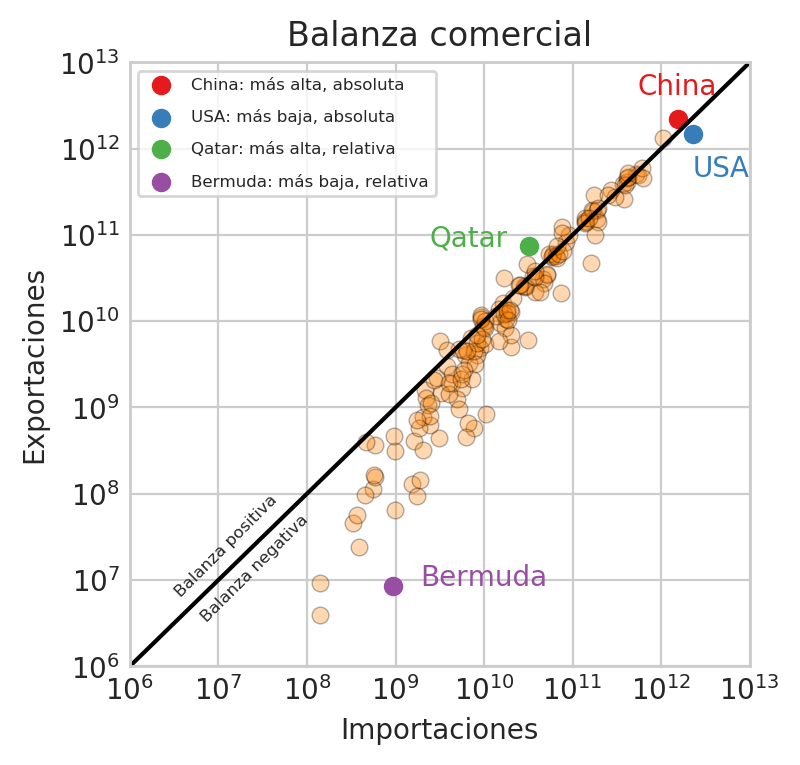

In [18]:
# paleta obtenida en http://colorbrewer2.org/?type=qualitative&scheme=Set1&n=5
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

plt.figure(figsize=(4, 4), dpi=200);
ax = plt.axes(xscale='log', yscale='log');
plt.xlim(1e6,1e13)
plt.ylim(1e6,1e13);
plt.title("Balanza comercial")
plt.xlabel("Importaciones")
plt.ylabel("Exportaciones")

# diagrama de puntos de todos los países
# descargamos las etiquetas para limitar la leyenda a los 4 valores anteriores
plt.scatter(df_grp.Import,
            df_grp.Export,
            label="_skip",
            color=colors[4], 
            linewidths=0.5,
            edgecolors="black",
            alpha=0.3)

# indicamos dónde está el punto de equilibrio
plt.plot([1e6, 1e14], [1e6, 1e14], color="black")
ax.text(3e6, 6e6,
        "Balanza positiva", 
        {'ha': 'left', 'va': 'bottom', 'size': 6},
        rotation=45)

ax.text(6e6, 3e6,
        "Balanza negativa", 
        {'ha': 'left', 'va': 'bottom', 'size': 6},
        rotation=45)

# marcamos los países que hemos indicado antes
ax.scatter(top1Abs.Import, top1Abs.Export, label=top1Abs.name + ": más alta, absoluta", color=colors[0])
ax.text(top1Abs.Import-1e12, top1Abs.Export+2e12, top1Abs.name, dict(size=10, color=colors[0]))
ax.scatter(bottom1Abs.Import, bottom1Abs.Export, label=bottom1Abs.name + ": más baja, absoluta", color=colors[1])
ax.text(bottom1Abs.Import, bottom1Abs.Export-1e12, bottom1Abs.name, dict(size=10, color=colors[1]));

ax.scatter(top1Norm.Import, top1Norm.Export, label=top1Norm.name + ": más alta, relativa", color=colors[2])
ax.text(top1Norm.Import-3e10, top1Norm.Export, top1Norm.name, dict(size=10, color=colors[2]))
ax.scatter(bottom1Norm.Import, bottom1Norm.Export, label=bottom1Norm.name + ": más baja, relativa", color=colors[3])
ax.text(bottom1Norm.Import+1e9, bottom1Norm.Export, bottom1Norm.name, dict(size=10, color=colors[3]));


plt.legend(scatterpoints=1, frameon=True,
           labelspacing=1, title='',
           loc="upper left", ncol=1,
           prop={'size': 6}, );

Hay que advertir que el gráfico anterior está en escala logarítmica para poder visualizar un rango que, como ya hemos dicho, es de varios órdenes de magnitud. La línea recta indica los valores de una balanza equilibrada, con un valor similar de exportaciones e importaciones. Los países se mueven entorno al punto de equilibro, si bien la mayoría tienen un déficit de exportaciones.

El país con mayor desequilibrio respecto a sus exportaciones totales es Bermuda. Tiene sentido ya que, al igual que las Islas Caimán, es un centro financiero y un destino turístico. Los países con la balanza más desequilibrada en valor absoluto son también los dos con el mayor volumen de exportaciones e importaciones: China y Estados Unidos. China consigue exportar más materias primas y bienes manufacturados de los que importa, mientras que Estados Unidos necesita importar más de lo que exporta.

<a id="Q2"></a>
### ¿Los intercambios comerciales se concentran en áreas geográficas cercanas?

Podemos pensar que, en un mundo globalizado, el intercambio de bienes no tiene fronteras. Esto podemos comprobarlo simplemente entrando en un supermercado y leyendo las etiquetas. Pero podemos preguntarnos: ¿es el comercio con los países vecinos predominante?

Para este análisis vamos a utilizar datos auxiliares proporcionados por el World Bank. Esta entidad ofrece datos de una gran variedad de indicadores económicos, pero sólo descargaremos unos metadatos que nos indican la zona geográfica de cada país.

In [19]:
if get_data_from_API:
    # documentación de la API en https://datahelpdesk.worldbank.org/knowledgebase/articles/902049
    wb_url = 'http://api.worldbank.org/v2/countries/?format=json&per_page=500'
    response = rq.get(wb_url)
    wb_md = json.loads(response.text)

    # transformamos el JSON en un dataframe para poder ejecutar joins con los datos de comercio
    names = []
    codes = []
    zones = []
    lats = []
    lons = []

    for country in wb_md[1]:
        if country['region']['value'] != 'Aggregates':
            names.append(country['name'])
            codes.append(country['id'])
            zones.append(country['region']['value'])
            lats.append(country['latitude'])
            lons.append(country['longitude'])

    countries = pd.DataFrame({'Name': names,
                              'Code': codes,
                              'Zone': zones,
                              'Lat': lats,
                              'Lon': lons})
    countries.to_csv("wb_countries_metadata.csv", index=False)
else:
    countries_resp = rq.get(metadatafile_github)
    countries = pd.read_csv(StringIO(countries_resp.text))

countries.head()


,Code,Lat,Lon,Name,Zone
0,ABW,12.5167,-70.0167,Aruba,Latin America & Caribbean
1,AFG,34.5228,69.1761,Afghanistan,South Asia
2,AGO,-8.81155,13.242,Angola,Sub-Saharan Africa
3,ALB,41.3317,19.8172,Albania,Europe & Central Asia
4,AND,42.5075,1.5218,Andorra,Europe & Central Asia


El siguiente paso es asignar una zona geográfica a cada país. Tanto los datos de Comtrade como los del World Bank utilizan códigos ISO de 3 caracteres para identificar países, así que usaremos esos códigos relacionar ambos datasets. Ejecutamos dos joins porque cada registro tiene dos códigos de país: el de origen y el de destino.

In [20]:
df_reg = df.merge(countries[['Code', 'Zone']], how='inner', left_on='SourceISO', right_on='Code')
del df_reg['Code']
df_reg.rename(columns={'Zone': 'SourceZone'}, inplace=True)
df_reg = df_reg.merge(countries[['Code', 'Zone']], how='inner', left_on='DestinationISO', right_on='Code')
del df_reg['Code']
df_reg.rename(columns={'Zone': 'DestinationZone'}, inplace=True)

A continuación calculamos el volumen de transacciones entre cada pareja de regiones. Los volúmenes son muy dispares, y nos interesa, más que el volumen absoluto, cómo de importante es el intercambio producido dentro de una zona respecto a los intercambios fuera de la zona. El comando *transform* nos permite normalizar los datos dentro de cada grupo, siendo cada grupo los intercambios con origen en una misma zona. De esta forma, obtenemos un dataframe con proporciones que suman 1 para cada zona.

In [21]:
grp_by_reg = (df_reg
              .groupby(by=['SourceZone', 'DestinationZone'],
                            as_index=False)
              .sum()[['SourceZone', 'DestinationZone', 'TradeValue']])

grp_by_reg['TradeValueNorm'] = grp_by_reg.groupby('SourceZone').transform(lambda x: x / x.sum())
grp_by_reg = grp_by_reg.pivot("SourceZone", "DestinationZone", "TradeValueNorm")


El resultado es una matrix cuadrada difícil de comprender a simple vista. Nos interesa más apreciar la tendencia global que los valores individuales, así que volcamos los datos en un heatmap.

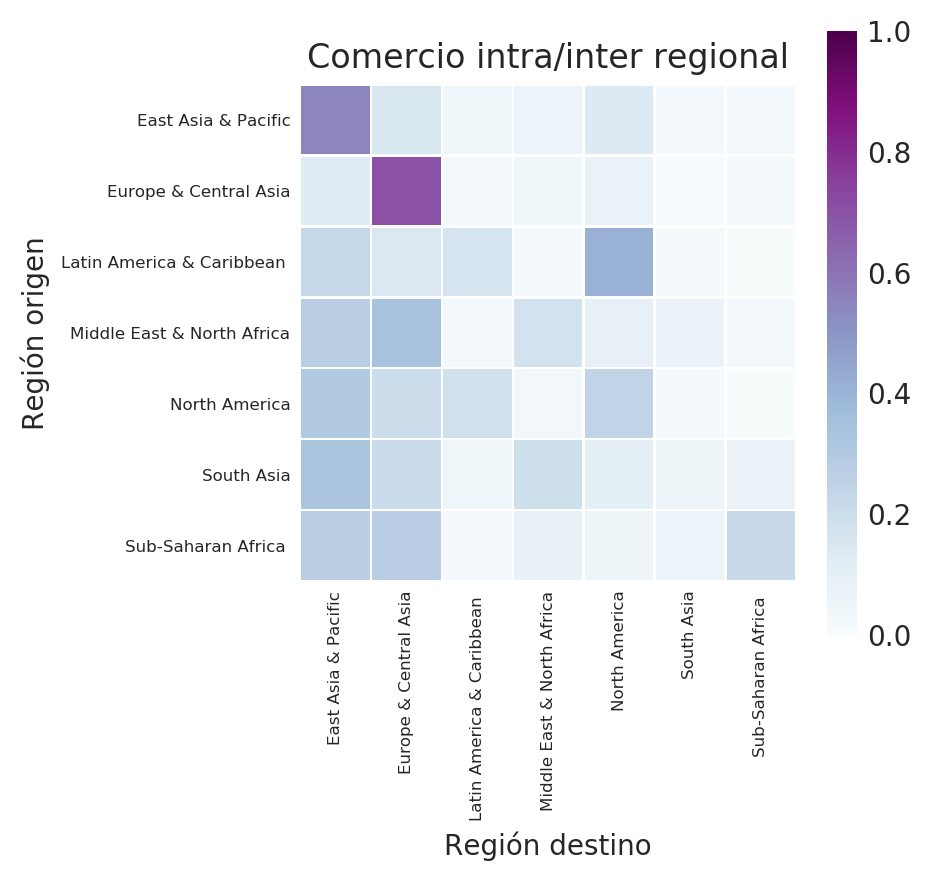

In [22]:
plt.figure(figsize=(4, 4), dpi=200);
ax = sns.heatmap(grp_by_reg,
            vmin=0, vmax=1,
            cmap="BuPu",
            linewidths=0.5,
            square=True);

ax.set_xlabel("Región destino")
ax.set_ylabel("Región origen")
ax.set_title("Comercio intra/inter regional")
ax.set_xticklabels(grp_by_reg.columns, fontdict=dict(size=6))
ax.set_yticklabels(grp_by_reg.index.values, fontdict=dict(size=6));


Podemos leer el gráfico de la siguiente manera: las celdas con colores oscuros indican un mayor volumen de transacciones entre esa pareja de zonas. La diagonal corresponde con los intercambios con origen y destino en la misma zona. Podemos observar que sólo en el caso de *Asia Oriental y Pacífico* y de *Europa y Asia Central*, los intercambios internos tienen una importancia superior a los externos. Si bien hablamos de intercambios internacionales en cualquier caso, y teniendo en cuenta que nos hemos normalizado los valores por distancia geográfico, podemos deducir que los países de las citadas regiones tienen a comerciar más con los países de su entorno.

En cuanto a los valores altos fuera de la diagonal saltan a la vista dos celdas: *Medio Oriente y África Septentrional* comercia principalmente con *Europa y Asia Central*, mientras que *América Latina y el Caribe* comercia sobre todo con *Norteamérica*. Si bien estos países están asignados a zonas geográficas distintas, la cercanía geográfica es relevante, ya que, por ejemplo, Sudamérica genera más intercambios con su vecina Norteamérica que con Europa.

<a id="Q3"></a>
### ¿Hay países que monopolizan la exportación de ciertos bienes?

Estos datos también nos pueden informar de cómo de monopolizados están ciertas materias primas y bienes manufacturados. Un análisis de este tipo nos permite extraer información sobre la dependencia que tenemos de ciertos países.

En este caso nos vamos a centrar en las exportaciones. En primer lugar vamos a detectar qué países acumulan un mayor porcentaje del volumen total de exportaciones de cada producto. Seguidamente, y como ejercicio complementario, detectaremos qué productos están mejor repartidos, en el sentido de que hay muchos países exportadores de dicho producto, cada uno con un porcentaje pequeño del volumen total.

Para detectar los países más monopolizadores, agrupamos por producto y país, calculamos el porcentaje de volumen por país dentro de cada producto, y listamos los porcentajes más altos.

In [23]:
# primer groupby: volumen total por producto y país
grp_by_cat = (df[df['Direction'] == "Export"]
              .groupby(by=["CommodityCode", "Source"], as_index=False)
              .sum()[['CommodityCode', 'Source', 'TradeValue']])
# segundo groupby: porcentaje del volumen que aporta cada país a cada producto
grp_by_cat["TradeValuePercent"] = (grp_by_cat
                                   .groupby('CommodityCode')
                                   .transform(lambda x: x / x.sum()))
# finalmente: añadimos las descripciones de nuevo (perdidas en el groupby) y descartamos columnas innecesarias
grp_by_cat = (grp_by_cat
              .merge(commodities,
                     how='inner',
                     left_on="CommodityCode",
                     right_on="Code"))[['Source', 'Code', 'TradeValuePercent', 'Description']]
              

In [24]:
# Estos son los países que más acaparan un producto concreto. No sorprende a nadie que China monopolice
# muchas materias primas y bienes de consumo
grp_by_cat.sort_values(by="TradeValuePercent", ascending=False).head(5)

,Source,Code,TradeValuePercent,Description
8957,China,66,0.810632,"Umbrellas, sun umbrellas, walking-sticks, seat..."
9081,China,67,0.777362,Prepared feathers and down and articles made o...
6292,China,46,0.689339,"Manufactures of straw, of esparto or of other ..."
6232,Portugal,45,0.628105,Cork and articles of cork
8819,China,65,0.549421,Headgear and parts thereof


La tabla anterior se lee de la siguiente manera: China acapara un 81.1% de las exportaciones totales de paraguas y bastones, un 77.7% de los productos derivados de plumas, y así sucesivamente.

---

Para la segunda parte del ejercicio, agrupamos los datos anteriores por producto y hallamos la desvicación estándar de los porcentajes atribuidos a cada país. Estos nos da una estimación de cómo de diferentes son los porcentajes que aporta cada país. En los productos muy monopolizados, como los paraguas, China acapara un 81%, así que sabemos que el siguiente país tendrá, como mucho, un 19%, y seguramente será aún menor. En productos muy repartidos, esperamos observar muchos valores muy bajos, en torno a 7-9%.

In [25]:
(grp_by_cat
 .groupby(by=["Code"], as_index=True)
 .std()
 .merge(commodities,
        how='inner',
        left_index=True,
        right_on="Code")
 .sort_values(by="TradeValuePercent", ascending=True)
 .head(5))

,TradeValuePercent,Code,Description
24,0.013334,25,Salt; sulphur; earths and stone; plastering ma...
23,0.015421,24,Tobacco and manufactured tobacco substitutes
10,0.015987,11,Products of the milling industry; malt; starch...
18,0.016245,19,"Preparations of cereals, flour, starch or milk..."
43,0.016468,44,Wood and articles of wood; wood charcoal


En la tabla anterior observamos que los productos "sales, tierras, piedras, etc." tienen los porcentajes menos repartidos. Un vistazo rápido nos permite ver los principales exportadores y sus contribuciones. De los 10 principales exportadores, ninguno acapara más de un 8.6%. 

In [26]:
grp_by_cat[grp_by_cat["Code"] == 25].sort_values(by="TradeValuePercent", ascending=False).head(10)

,Source,Code,TradeValuePercent,Description
3418,China,25,0.085993,Salt; sulphur; earths and stone; plastering ma...
3523,USA,25,0.067154,Salt; sulphur; earths and stone; plastering ma...
3439,Germany,25,0.056850,Salt; sulphur; earths and stone; plastering ma...
3522,Turkey,25,0.054531,Salt; sulphur; earths and stone; plastering ma...
3448,India,25,0.044192,Salt; sulphur; earths and stone; plastering ma...
3416,Canada,25,0.033851,Salt; sulphur; earths and stone; plastering ma...
3511,Spain,25,0.033793,Salt; sulphur; earths and stone; plastering ma...
3471,Morocco,25,0.033379,Salt; sulphur; earths and stone; plastering ma...
3526,United Arab Emirates,25,0.031985,Salt; sulphur; earths and stone; plastering ma...
3401,Belgium,25,0.031580,Salt; sulphur; earths and stone; plastering ma...


Estos resultados nos permiten concluir que hay productos extremadamente monopolizados, mientras que hay otros en los que el mercado está muy disgregado. Para apreciar visualmente estas diferencias vamos a preparar varios diagramas [*Sankey*](https://es.wikipedia.org/wiki/Diagrama_de_Sankey): dos para productos muy monopolizados y dos para productos muy distribuidos. Se pueden obtener otros diagramas cambiando los códigos de la lista *plot_commodities*.

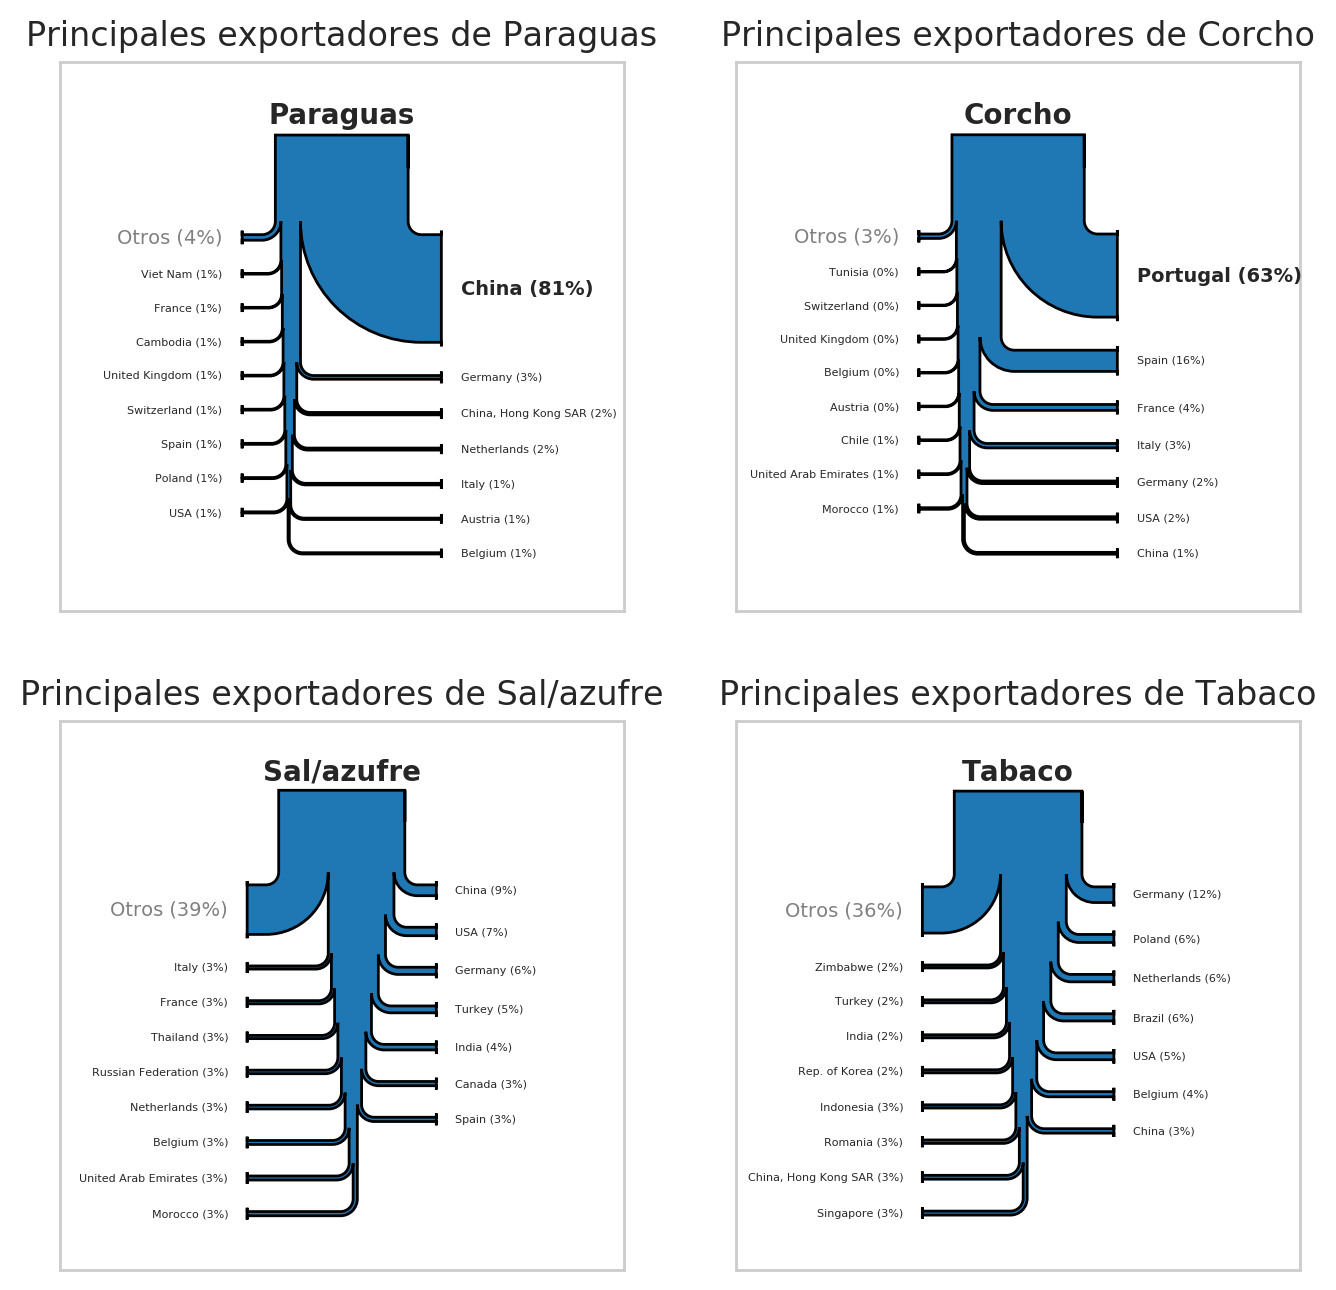

In [27]:
from matplotlib.sankey import Sankey

plot_commodities = {
    66: "Paraguas",
    45: "Corcho",
    25: "Sal/azufre",
    24: "Tabaco"    
}

i = 0
fig = plt.figure(figsize=(8, 8), dpi=200)

for code, title in plot_commodities.items():
    i = i+1
    
    # extraemos los datos del producto
    # incluso para productos muy monopolizados, lo normal es que haya más de 100 países productores, así que
    # limitamos el número de países a los 15 primeros y agrupamos el resto en "Otros"
    
    comm_summary = grp_by_cat[grp_by_cat['Code'] == code].sort_values(by="TradeValuePercent", ascending=False)
    comm_summary['TradeValueCumulative'] = comm_summary.cumsum()['TradeValuePercent']
    comm_summary = comm_summary.iloc[0:15]

    # configuramos los porcentajes de cada flujo del Sankey:
    # - el producto es el input del Sankey y siempre es 100
    # - cada país es un output, así que tiene un valor negativo igual a su porcentaje
    # - "Otros" es también negativo y se calcula para que todos los flujos (inputs+outputs) sea cero
    flows = list([100])
    flows.extend(-(comm_summary['TradeValuePercent'].values * 100))
    flows.append(-(sum(flows)))

    # mostramos las etiquetas como "País (porcentaje %)"; el objeto Sankey puede mostrar
    # números en las etiquetas pero es menos configurable
    labels = list([title])
    labels.extend(comm_summary['Source'].values)
    labels.append("Otros")
    labels = ["{0} ({1:.0f}%)".format(l, abs(f)) for l, f in zip(labels, flows)]

    # orientamos las flechas a derecha e izquierda para hacer el sankey más legible
    orientations = list([0])
    orientations.extend([1] * (comm_summary.shape[0] //2))
    orientations.extend([-1] * (len(flows)-len(orientations)))

    
    ax = fig.add_subplot(2, 2, i, xticks=[], yticks=[], title="Principales exportadores de " + title)
    sankey = Sankey(ax=ax, scale=0.01, offset=0.15, head_angle=180, unit=None)
    sankey.add(flows=flows,
               labels=labels,
               orientations=orientations,
               rotation=270)
    diagrams = sankey.finish();
    
    # configuración de etiquetas
    for j in range(0,len(labels)):
        # etiquetas pequeñas por defecto
        diagrams[0].texts[j].set_size(4)
        
        # alineamos al final de las flechas
        if(diagrams[0].angles[j] == 4):
            diagrams[0].texts[j].set_ha('left')
        else:
            diagrams[0].texts[j].set_ha('right')
        
        # coloreamos "Otros" en gris y agrandamos
        if (j == len(labels)-1):
            diagrams[0].texts[j].set_size(7)
            diagrams[0].texts[j].set_color("grey")
        
        # tratamos la etiqueta del producto de manera especial
        if j == 0:
            diagrams[0].texts[j].set_size(10)
            diagrams[0].texts[j].set_ha('center')
            diagrams[0].texts[j].set_text(title)
            diagrams[0].texts[j].set_weight('bold')
        
        # resaltamos los principales productores
        if diagrams[0].flows[j] < -50:
            diagrams[0].texts[j].set_size(7)
            diagrams[0].texts[j].set_weight('bold')
        


Podemos leer estos diagramas de la siguiente manera: la producción global de un producto es el 100% del flujo de entrada, que se disgrega en muchos flujos de salida, uno por país. Hay un flujo etiquetado como **Otros** que agrupa los exportadores con menor volumen. Normalmente hay más de 100 exportadores de cada producto, así que limitamos el diagrama al top 15 para que sea legible.

Estas visualizaciones corroboran que la tendencia al monopolio no es general y que hay que revisar cada producto en detalle para conocer la situación de dicho mercado.

<a id="conclusiones"></a>
## Conclusiones y próximos pasos

En este análisis de los datos de comercio internacional proporcionados por la ONU hemos llegado a las siguientes conclusiones:
- La mayoría de los países son netamente importadores de materias primas y bienes manufacturados. Los países con mayor volumen de comercio son, como cabía esperar, China y Estados Unidos.
- El comercio con países cercanos sigue siendo más importante que el comercio de larga distancia.
- Hay productos claramente monopolizados por uno o dos países, pero también hay productos con un mercado mucho más segregado.

Estas respuestas no hacen más que plantear nuevas preguntas. Por ejemplo, sería interesante estudiar también las categorías de servicios para determinar si los países compensan una balanza comercial de productos negativa con un volumen positivo de servicios. Se podría mejorar el análisis de comercio regional afinando las distancias entre parejas de países con, por ejemplo, coordenadas geográficas medias o considerando como países vecinos sólo a aquellos que comparten frontera. Finalmente, se podría dar la vuelta a la última pregunta y comprobar si hay países que dependan excesivamente de la exportación de un único producto, o si hay países que acaparan la compra de una materia prima.